# Streaming

## Review

In module 2, covered a few ways to customize graph state and memory.

We built up to a Chatbot with external memory that can sustain long-running conversations.

## Goals

This module will dive into `human-in-the-loop`, which builds on memory and allows users to interact directly with graphs in various ways.

To set the stage for `human-in-the-loop`, we'll first dive into streaming, which provides several ways to visualize graph output (e.g., node state or chat model tokens) over the course of execution.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_google_genai langgraph_sdk

## Streaming

LangGraph is built with [first class support for streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

Let's set up our Chatbot from Module 2, and show various way to stream outputs from the graph during execution.

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
if not GEMINI_API_KEY:
    raise ValueError("GEMINI_API_KEY is not set in the .env file.")
print("Gemini api key loaded successfully")

Gemini api key loaded successfully


Note that we use `RunnableConfig` with `call_model` to enable token-wise streaming. This is [only needed with python < 3.11](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/). We include in case you are running this notebook in CoLab, which will use python 3.x.

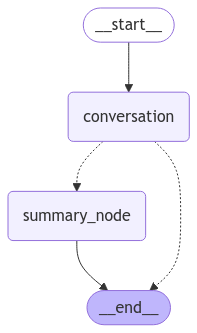

summary printing

summary printing

summary printing

summary printing

================================== Ai Message ==================================

Your major is mathematics.


In [5]:
from langgraph.graph import START,END,StateGraph
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display,Image
from langchain_core.messages import HumanMessage,SystemMessage,RemoveMessage
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph import add_messages
from typing import Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import RunnableConfig

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=GEMINI_API_KEY)

class StateClass(MessagesState):
    summary: str
    messages:Annotated[list[AnyMessage],add_messages]
    
def start_conversation(state:StateClass,config:RunnableConfig):
    summary = state.get('summary','')
    print("summary printing")
    print(summary)
    
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content = system_message)] + state['messages']
    else:
        messages = state['messages']
    # result =  llm.invoke(messages,config)  #Note that we use `RunnableConfig` with `start_conversation` to enable token-wise streaming.
    result =  llm.invoke(messages)
    return {'messages':result}     
            
def call_summary(state:StateClass):
    summary = state.get('summary','')
    if summary:
        human_message = (
            f"This is the summary of the conversation to date: {summary}\n\n"
             "Extend the summary by taking into account the new messages above:"
        )
    else:
        human_message = "Create a summary of the conversation above:"
    messages = state['messages'] + [HumanMessage(content = human_message)]
    generate_summary = llm.invoke(messages)
     
        
    last_two_messages = [RemoveMessage(id=i.id) for i in state['messages'][:-2]] 
    return { 'summary':generate_summary.content,'messages':last_two_messages,}   
        
def decide_node(state:StateClass):
    messages = state['messages']
    if len(messages) > 10:
        return "summary_node"
    else:
        return END
 
memory = MemorySaver()

graph_building: StateGraph = StateGraph(StateClass)
graph_building.add_node("conversation", start_conversation)
graph_building.add_node("summary_node",call_summary)

graph_building.add_edge(START, "conversation")
graph_building.add_conditional_edges("conversation", decide_node)
graph_building.add_edge("summary_node", END)
 
 
 
 
 
final_graph  = graph_building.compile(checkpointer=memory)
display(Image(final_graph.get_graph().draw_mermaid_png())) 

  
config = {'configurable': {'thread_id':'1'}}

input = HumanMessage(content="Hi I am aramn")
final_resp =final_graph.invoke({"messages":[input]},config)
 

input = HumanMessage(content="I Like Programming")
final_resp =final_graph.invoke({"messages":[input]},config)
 

input = HumanMessage(content="I am major in math")
final_resp =final_graph.invoke({"messages":[input]},config)

input = HumanMessage(content="what is major i am")
final_resp =final_graph.invoke({"messages":[input]},config)
 
for m in final_resp['messages'][-1:]:
    m.pretty_print()   
 

In [28]:
input = HumanMessage(content="What is my name?")
for chunk in final_graph.stream({'messages':input},config,stream_mode ='updates'):
    print(chunk)
    

summary printing
Aramn likes programming. Aramn is majoring in math.

{'conversation': {'messages': AIMessage(content='Your name is Aramn.\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-cf0ad17e-faa6-4b0b-9107-7ac15b790209-0', usage_metadata={'input_tokens': 38, 'output_tokens': 7, 'total_tokens': 45, 'input_token_details': {'cache_read': 0}})}}
{'summary_node': {'summary': 'Aramn likes programming. Aramn is majoring in math.\n', 'messages': [RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='a5c84617-bd58-485c-9d8a-5c196932fbd6'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='run-d6c5b20d-7b88-4d49-993f-3bb91153bd40-0')]}}


In [32]:
for chunk in final_graph.stream({"messages": [HumanMessage(content="what is my name")]}, config, stream_mode="updates"):
    for i in chunk['messages']:
        i.pretty_print()

summary printing
The conversation to date includes:  Aramn likes programming. Aramn is majoring in math.  Lance introduced himself.



KeyError: 'messages'

### Streaming full state

Now, let's talk about ways to [stream our graph state](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

`.stream` and `.astream` are sync and async methods for streaming back results.

LangGraph supports a few [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) for [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):

* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after node in the graph is run.

Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

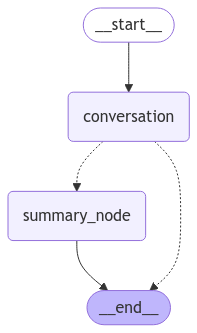

In [7]:
from langgraph.graph import START,END,StateGraph
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display,Image
from langchain_core.messages import HumanMessage,SystemMessage,RemoveMessage
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph import add_messages
from typing import Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import RunnableConfig

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=GEMINI_API_KEY)

class StateClass(MessagesState):
    summary: str
    messages:Annotated[list[AnyMessage],add_messages]
    
def start_conversation(state:StateClass,config:RunnableConfig):
    summary = state.get('summary','')
 
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content = system_message)] + state['messages']
    else:
        messages = state['messages']
    # result =  llm.invoke(messages,config)  #Note that we use `RunnableConfig` with `start_conversation` to enable token-wise streaming.
    result =  llm.invoke(messages)
    return {'messages':result}     
            
def call_summary(state:StateClass):
    summary = state.get('summary','')
    if summary:
        human_message = (
            f"This is the summary of the conversation to date: {summary}\n\n"
             "Extend the summary by taking into account the new messages above:"
        )
    else:
        human_message = "Create a summary of the conversation above:"
    messages = state['messages'] + [HumanMessage(content = human_message)]
    generate_summary = llm.invoke(messages)
     
        
    last_two_messages = [RemoveMessage(id=i.id) for i in state['messages'][:-2]] 
    return { 'summary':generate_summary.content,'messages':last_two_messages,}   
        
def decide_node(state:StateClass):
    messages = state['messages']
    if len(messages) > 10:
        return "summary_node"
    else:
        return END
 
memory = MemorySaver()

graph_building: StateGraph = StateGraph(StateClass)
graph_building.add_node("conversation", start_conversation)
graph_building.add_node("summary_node",call_summary)

graph_building.add_edge(START, "conversation")
graph_building.add_conditional_edges("conversation", decide_node)
graph_building.add_edge("summary_node", END) 
final_graph  = graph_building.compile(checkpointer=memory)
display(Image(final_graph.get_graph().draw_mermaid_png())) 

In [22]:
input = HumanMessage(content="please write an essay of pakistan in 1300 words")
for chunk in final_graph.stream({'messages':[input]},config,stream_mode='updates'):
    print(chunk)
     
  

{'conversation': {'messages': AIMessage(content="Pakistan, a nation born from the tumultuous partition of India in 1947, presents a complex and multifaceted tapestry of history, geography, culture, and politics.  Its journey has been marked by both remarkable achievements and persistent challenges, shaping its identity as a nation striving for stability and progress in a volatile region.  Understanding Pakistan requires a nuanced appreciation of its diverse landscapes, its rich cultural heritage, its turbulent political history, and the ongoing economic and security concerns that continue to shape its destiny.\n\nGeographically, Pakistan is a land of stark contrasts.  From the snow-capped peaks of the Himalayas and Karakoram ranges, home to K2, the world's second-highest mountain, to the arid deserts of Balochistan and the fertile alluvial plains of the Indus River valley, the country encompasses a wide range of terrains.  The Indus River, the lifeblood of the nation, has nurtured civi

In [23]:
input = HumanMessage(content="please write an essay of pakistan in 1300 words")
for chunk in final_graph.stream({'messages':[input]},config,stream_mode='values'):
    print(chunk)
     
  

{'messages': [HumanMessage(content='please write an essay of pakistan in 1300 words', additional_kwargs={}, response_metadata={}, id='a6525396-312a-459f-90e8-f4dc815f27c5'), AIMessage(content="Pakistan, a nation forged in the crucible of partition in 1947, stands as a testament to both remarkable resilience and persistent challenges.  Its journey, marked by periods of political instability, economic hardship, and security concerns, is interwoven with a rich tapestry of cultural heritage, geographical diversity, and a burgeoning young population.  Understanding Pakistan requires navigating these complex and often contradictory facets of its identity.\n\nGeographically, Pakistan is a land of striking contrasts.  From the towering peaks of the Himalayas and Karakoram ranges, home to some of the world's highest mountains, to the arid deserts of Balochistan and the fertile plains of the Indus River valley, the country presents a breathtaking panorama.  This diverse landscape has shaped its 

In [15]:
config = {"configurable": {"thread_id": "12"}}
input = HumanMessage(content="please write an essay of pakistan in 300 words")
for event in final_graph.stream({'messages':[input]},config,stream_mode='values'):
    for chunk in event['messages']:
       
        print('+++++++++++++++++++++++++++++++++++++++') 
        print(chunk.pretty_print) 

+++++++++++++++++++++++++++++++++++++++
<bound method BaseMessage.pretty_print of HumanMessage(content='please write an essay of pakistan in 300 words', additional_kwargs={}, response_metadata={}, id='279d1851-f339-498f-b43f-f5d68a623023')>
+++++++++++++++++++++++++++++++++++++++
<bound method BaseMessage.pretty_print of HumanMessage(content='please write an essay of pakistan in 300 words', additional_kwargs={}, response_metadata={}, id='279d1851-f339-498f-b43f-f5d68a623023')>
+++++++++++++++++++++++++++++++++++++++
<bound method BaseMessage.pretty_print of AIMessage(content="Pakistan, a nation forged in the crucible of partition in 1947, is a land of vibrant contrasts.  From the towering Karakoram Range in the north to the Arabian Sea in the south, its geography is breathtakingly diverse, encompassing fertile plains, arid deserts, and snow-capped mountains. This geographical diversity is mirrored in its cultural tapestry, a rich blend of ethnicities, languages, and traditions.  Punjab

### Streaming tokens

We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:

* `event`: This is the type of event that is being emitted.
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [20]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="what is my name")
async for event in final_graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

Your| name is Arman.
|